In [2]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool


import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis')
#sys.path.insert(0,'/groups/astro/robinboe/mass_analysis/computable-information-density')
#from joblib import Parallel, delayed

from ComputableInformationDensity.cid import interlaced_time, cid2d
from ComputableInformationDensity.computable_information_density import cid

# Get absolute path to this notebook
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))
from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean

In [4]:
LL = 512
base_path = f'Z:\\cid\\na{LL}'
save_path = f'data\\nematic\\\\na{LL}'

act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]
act_list.sort()
act_list;

In [9]:
act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list[1] = 0.21
# sort act_list and act_dir_list by act_list
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

LL = 512
nexp=5
output_suffix='_nb5cg4'
output_suffix='_lz77_c4_nb5_o0_c4'

# extract parameter dict for first run
exp_dirs = [x[0] for x in os.walk(act_dir_list[0])][1:]
with open(os.path.join(exp_dirs[0]  , f'cid_params{output_suffix}.pkl'), 'rb') as f:
        cid_params = pkl.load(f)

In [7]:
os.listdir(exp_dirs[0])

['cid_lz77_c4_nb5_o0_c4.npz', 'cid_params_lz77_c4_nb5_o0_c4.pkl']

In [10]:
extract = True
cid_suff = cid_params['cid_mode']

nhilbert_views = 8
nshuffle = cid_params['nshuffle']
ncubes = cid_params['ncubes']


#exp_list = [i for i in range(nexp)]

base_path = f'Z:\\cid\\na{LL}'
outpath = f'data\\nematic\\na{LL}'
if not os.path.exists(outpath):
    os.makedirs(outpath)

act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list.sort()
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

cid_arr = np.nan * np.zeros((ncubes, len(act_list), nexp, 2))
cid_shuffle_arr = np.nan * np.zeros((ncubes, len(act_list), nexp, 2))
cid_frac_arr = np.nan * np.zeros((ncubes, len(act_list), nexp, 2))

if extract:

    for i, act_dir in enumerate(act_dir_list):
        exp_dir_list =  [x[0] for x in os.walk(act_dir)][1:]
        #exp_dir_list = [x for _, x in sorted(zip(exp_list, exp_dir_list))]
        for j, exp_dir in enumerate(exp_dir_list):
            # load cid.pkl if it exists
            try:
                data_npz = np.load(os.path.join(exp_dir, f'cid{output_suffix}.npz'), allow_pickle=True)
            except:
                print(f'cid{output_suffix}.npz not found in {exp_dir}, skipping...')
                continue
           # with open(os.path.join(exp_dir, f'cid_{output_suffix}.pkl'), 'rb') as f:
            #    cid_dict = pkl.load(f)
            nframes = data_npz['cid'].shape[0]
            # extract cid values
            cid_arr[-nframes:, i, j, :] = data_npz['cid']
            cid_shuffle_arr[-nframes:, i, j, :] = data_npz['cid_shuffle']


    cid_frac_arr[:,:,:,0] = cid_arr[:,:,:,0] / cid_shuffle_arr[:,:,:,0]
    cid_frac_arr[:,:,:,1] = cid_frac_arr[:,:,:,0] * np.sqrt( (cid_arr[:,:,:,1]/cid_arr[:,:,:,0])**2 + (cid_shuffle_arr[:,:,:,1]/cid_shuffle_arr[:,:,:,0])**2 )

    # save cid_arr, cid_shuffle_arr, cid_frac_arr
    np.savez_compressed(os.path.join(outpath, f'cid_data{output_suffix}.npz'), cid=cid_arr, cid_shuffle=cid_shuffle_arr, cid_frac=cid_frac_arr, act_list=act_list)
else:
    data_npz = np.load(os.path.join(outpath, f'cid_data{output_suffix}.npz'), allow_pickle=True)
    cid_arr = data_npz['cid']
    cid_shuffle_arr = data_npz['cid_shuffle']
    cid_frac_arr = data_npz['cid_frac']
    act_list = data_npz['act_list']


In [17]:
cid_frac_arr[:,4,:,1]

array([[0.01305232, 0.0086943 , 0.01076317, 0.01213597, 0.01863808],
       [0.00681696, 0.01184739, 0.00931202, 0.01861268, 0.00918226],
       [0.01295068, 0.00717367, 0.00911411, 0.01488073, 0.0155526 ],
       [0.01217845, 0.01055145, 0.00702532, 0.00801029, 0.00896946],
       [0.00798683, 0.01094172, 0.00793707, 0.01267749, 0.00992194],
       [0.01284028, 0.01223453, 0.00925892, 0.01123608, 0.01502338],
       [0.00604667, 0.01238386, 0.00593195, 0.01047287, 0.01032199],
       [0.01089619, 0.00687452, 0.00943094, 0.0095569 , 0.01009659],
       [0.00761349, 0.01053578, 0.00999568, 0.01380065, 0.00818697],
       [0.00683459, 0.01151307, 0.00727527, 0.01343302, 0.00860965],
       [0.00768057, 0.01240099, 0.01134077, 0.01080382, 0.01244715],
       [0.0079822 , 0.01040621, 0.01040882, 0.00910582, 0.01271697]])

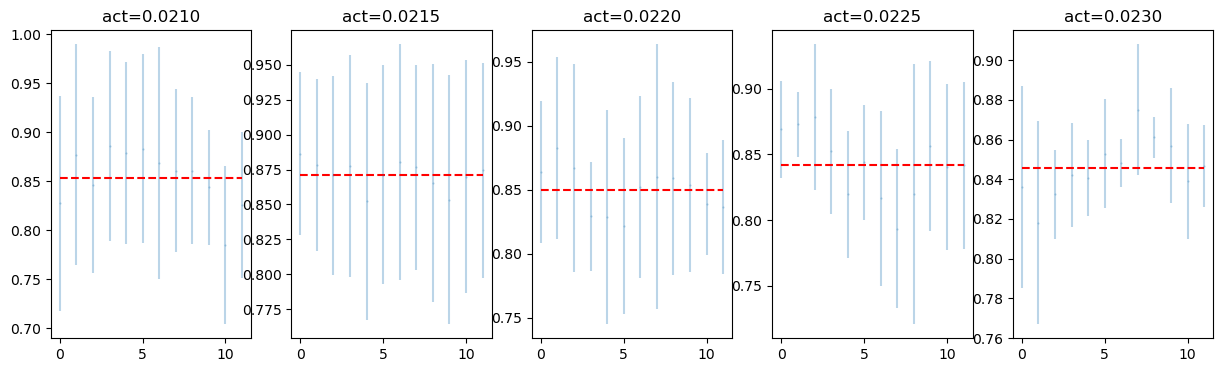

In [11]:
# plot mean and std of cid_arr, cid_shuffle_arr, cid_frac_arr over nexp for each act
ncols=5
fig, ax = plt.subplots(ncols=ncols,figsize=(15,4))
for i, act in enumerate(act_list[3:3+ncols]):

    ax[i].errorbar(np.arange(ncubes), np.nanmean(cid_frac_arr[:,i,:,0], axis=-1), yerr=np.nanstd(cid_frac_arr[:,i,:,0], axis=-1), fmt='.', label=f'act={act}',alpha=.3,ms=1)
    ax[i].hlines(np.nanmean(cid_frac_arr[:,i,:,0]), 0, ncubes-1, colors='r', linestyles='--', label='mean last 10')
    ax[i].set_title(f'act={act:.4f}')
                                                                   


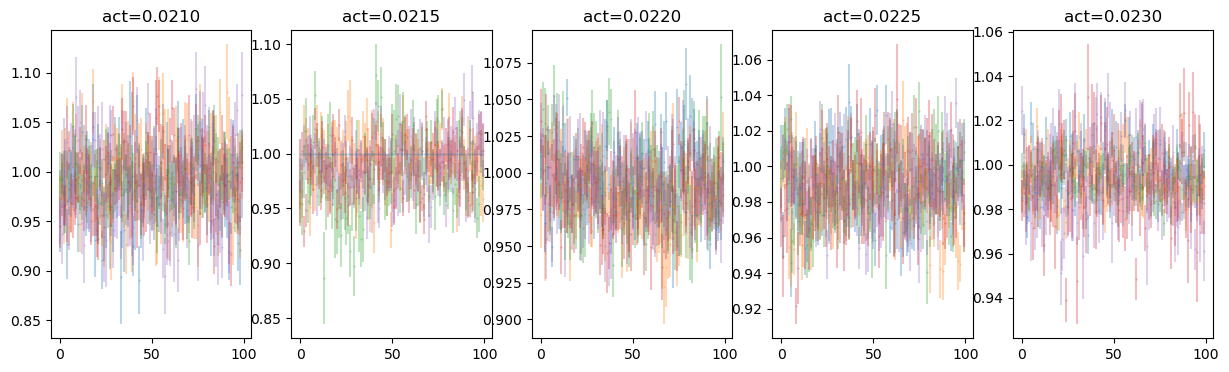

In [ ]:
# plot mean and std of cid_arr, cid_shuffle_arr, cid_frac_arr over nexp for each act
ncols=5
fig, ax = plt.subplots(ncols=ncols,figsize=(15,4))
for i, act in enumerate(act_list[3:3+ncols]):
    for j in range(nexp):
        ax[i].errorbar(np.arange(ncubes), np.nanmean(cid_frac_arr[:,i,:,0], axis=0), yerr=cid_frac_arr[:,i,j,1], fmt='.', label=f'exp={j}',alpha=.3,ms=1)
                                                                            
    ax[i].set_title(f'act={act:.4f}')
                                                                   


(0.016, 0.03)

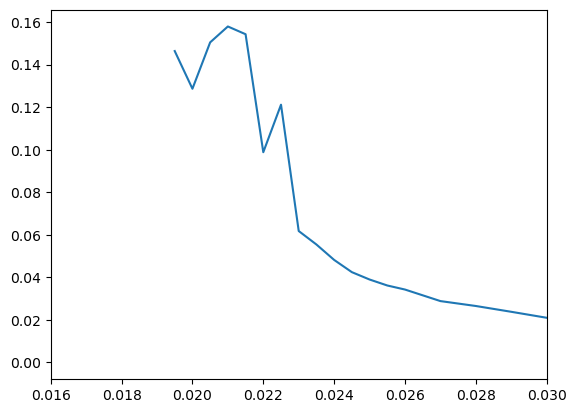

In [14]:
plt.plot(act_list, 1 - np.nanmean(cid_arr[:,:,:,0]/cid_shuffle_arr[:,:,:,0], axis=(0,2)))
plt.xlim(0.016,0.03)

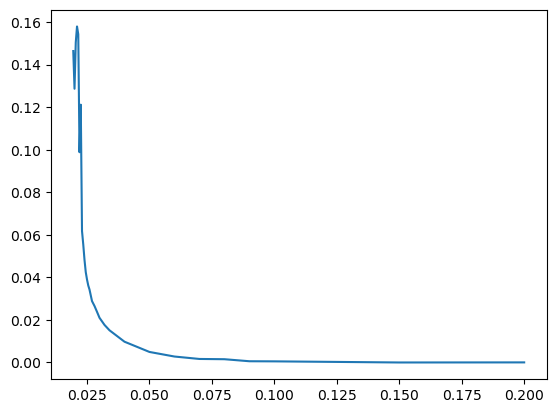

In [15]:
plt.plot(act_list, 1 - np.nanmean(cid_frac_arr[:,:,:,0], axis=(0,2)))

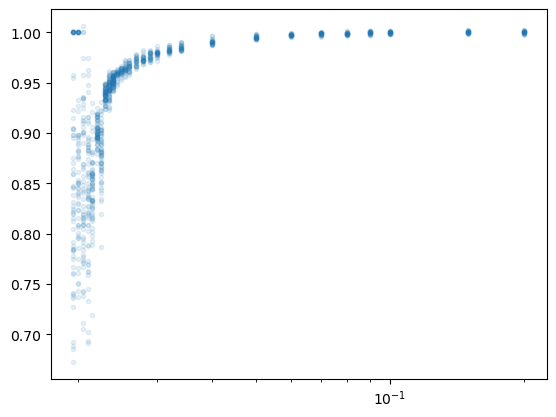

In [18]:
act_expanded = np.repeat(np.array(act_list)[None,:], ncubes, axis=0)
act_expanded = np.repeat(act_expanded[:,:,None], nexp, axis=2)
plt.scatter(act_expanded, cid_frac_arr[:,:,:,0], marker='.', alpha=0.1)
plt.xscale('log')

In [ ]:
extract = True
cid_suff = cid_params['cid_mode']

nhilbert_views = 8
nshuffle = cid_params['nshuffle']
ncubes = cid_params['ncubes']


exp_list = [i for i in range(nexp)]

base_path = f'Z:\\cid\\na{LL}'
outpath = f'data\\nematic\\na{LL}'
if not os.path.exists(outpath):
    os.makedirs(outpath)

act_dir_list = [os.path.join(base_path, os.listdir(base_path)[i]) for i in range(len(os.listdir(base_path)))]
act_list = [float(os.listdir(base_path)[i].split('_')[-1]) for i in range(len(os.listdir(base_path)))]

act_list.sort()
act_dir_list = [x for _, x in sorted(zip(act_list, act_dir_list))]

cid_arr = np.zeros((len(act_list), nexp, 2))
cid_shuffle_arr = np.zeros((len(act_list), nexp, 2))
cid_frac_arr = np.zeros((len(act_list), nexp, 2))

if extract:

    for i, act_dir in enumerate(act_dir_list):
        exp_dir_list =  [x[0] for x in os.walk(act_dir_list)][1:]
        #exp_dir_list = [x for _, x in sorted(zip(exp_list, exp_dir_list))]
        for j, exp_dir in enumerate(exp_dir_list):
            # load cid.pkl if it exists
            with open(os.path.join(exp_dir, f'cid_{output_suffix}.pkl'), 'rb') as f:
                cid_dict = pkl.load(f)

            # extract cid values
            cid_arr[i, j, :] = cid_dict['cid']
            cid_shuffle_arr[i, j, :] = cid_dict['cid_shuffle']

    # converts stds to sems
    cid_arr[:,:,1 ] = cid_arr[:,:,1] / np.sqrt(nhilbert_views)
    cid_shuffle_arr[:,:,1 ] = cid_shuffle_arr[:,:,1] / np.sqrt(nshuffle)

cid_frac_arr[:,:,0] = cid_arr[:,:,0] / cid_shuffle_arr[:,:,0]
cid_frac_arr[:,:,1] = cid_frac_arr[:,:,0] * np.sqrt( (cid_arr[:,:,1]/cid_arr[:,:,0])**2 + (cid_shuffle_arr[:,:,1]/cid_shuffle_arr[:,:,0])**2 )


In [125]:
act_expanded = np.repeat(np.array(act_list)[:,None], nexp, axis=1)
act_expanded

array([[0.0195, 0.0195, 0.0195, 0.0195, 0.0195],
       [0.02  , 0.02  , 0.02  , 0.02  , 0.02  ],
       [0.0205, 0.0205, 0.0205, 0.0205, 0.0205],
       [0.021 , 0.021 , 0.021 , 0.021 , 0.021 ],
       [0.0215, 0.0215, 0.0215, 0.0215, 0.0215],
       [0.022 , 0.022 , 0.022 , 0.022 , 0.022 ],
       [0.0225, 0.0225, 0.0225, 0.0225, 0.0225],
       [0.023 , 0.023 , 0.023 , 0.023 , 0.023 ],
       [0.0235, 0.0235, 0.0235, 0.0235, 0.0235],
       [0.024 , 0.024 , 0.024 , 0.024 , 0.024 ]])

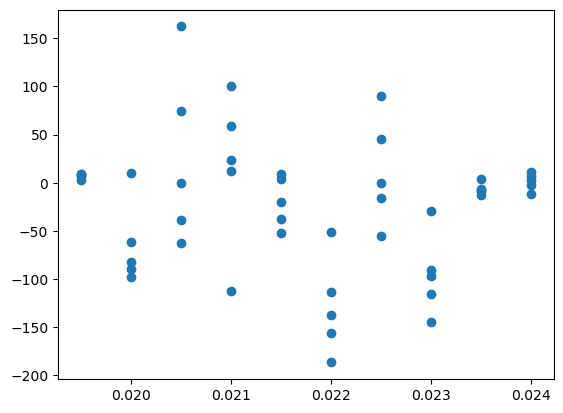

In [127]:
act_expanded = np.repeat(np.array(act_list)[:,None], nexp, axis=1)
plt.scatter(act_expanded, divdz, marker='o')

In [109]:
cid_frac_arr[:,1,0]

array([0.86579064, 0.86099673, 0.89221275, 0.88059938, 0.87598196,
       0.93274541, 0.93279314, 0.99069615, 0.98873841, 0.98755735])

In [90]:
cid_frac_arr[1,:,0]

array([1.        , 0.86099673, 0.84436973, 0.85833234, 0.89399531])

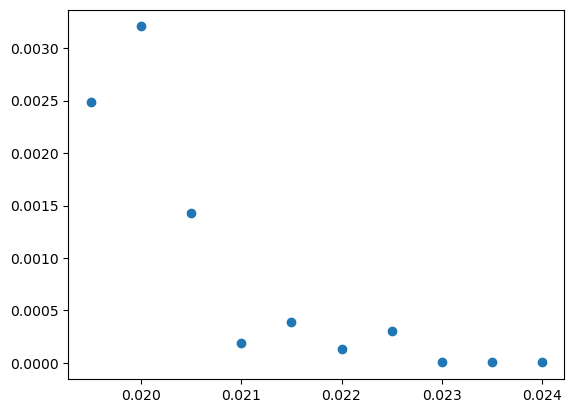

In [76]:
#plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1))
plt.scatter(act_list, np.var(cid_frac_arr[:,:,0], axis=1))

In [ ]:
plot_divergence=True
nhilbert_views = 8
nshuffle = 8

cid_mean = np.mean(cid_arr[:,:,0], axis=1) 
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_mean_weighted, cid_std_weighted = calc_weighted_mean(cid_arr[:,:,0], cid_arr[:,:,1], omit_null_uncertainties=True)
cid_shuffle_mean_weighted, cid_shuffle_std_weighted = calc_weighted_mean(cid_shuffle_arr[:,:,0], cid_shuffle_arr[:,:,1], omit_null_uncertainties=True)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

cid_ratio_weighted = cid_mean_weighted / cid_shuffle_mean_weighted  
cid_ratio_std_weighted = np.sqrt((cid_std_weighted)**2 + (cid_ratio_weighted)**2 * (cid_shuffle_std_weighted)**2) / cid_shuffle_mean_weighted

if plot_divergence:
    plt.scatter(act_list, 1-np.mean(cid_frac_arr[:,:,0], axis=1), marker='x')
    plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
    plt.errorbar(act_list, 1-cid_ratio_weighted, yerr=cid_ratio_std_weighted, label='1 - (CID Weighted / CID Shuffle Weighted)', fmt='o-')
    plt.ylabel('1 - (CID / CID Shuffle)')
else:
    plt.errorbar(act_list, cid_shuffle_mean_weighted, yerr=cid_shuffle_std_weighted, label='CID Shuffle Weighted', fmt='o-')
    plt.errorbar(act_list, cid_mean_weighted, yerr=cid_std_weighted, label='CID Weighted', fmt='o-')
    plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
    plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
    plt.ylabel('CID')
    #plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
#plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.legend()

Text(0, 0.5, '1 - (CID / CID Shuffle)')

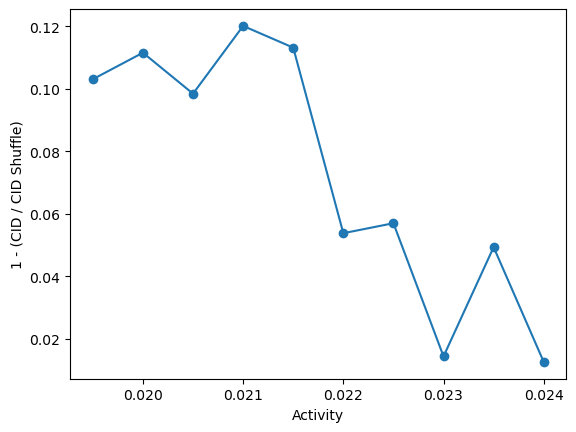

In [36]:
cid_mean = np.mean(cid_arr[:,:,0], axis=1)
cid_std = (np.std(cid_arr[:,:,0], axis=1) + np.mean(cid_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_shuffle_mean = np.mean(cid_shuffle_arr[:,:,0], axis=1)
cid_shuffle_std = (np.std(cid_shuffle_arr[:,:,0], axis=1) + np.mean(cid_shuffle_arr[:,:,1], axis=1)) / np.sqrt(nexp)

cid_ratio = cid_mean / cid_shuffle_mean
cid_ratio_std = cid_ratio * np.sqrt((cid_std/cid_mean)**2 + (cid_shuffle_std/cid_shuffle_mean)**2)
cid_ratio_std = np.sqrt((cid_std)**2 + (cid_ratio)**2 * (cid_shuffle_std)**2) / cid_shuffle_mean

#plt.errorbar(act_list, cid_shuffle_mean, yerr=cid_shuffle_std, label='CID Shuffle', fmt='o-')   
#plt.errorbar(act_list, cid_mean, yerr=cid_std, label='CID', fmt='o-')
#plt.errorbar(act_list, 1-cid_ratio, yerr=cid_ratio_std, label='1 - (CID / CID Shuffle)', fmt='o-')
plt.plot(act_list, 1-cid_ratio, 'o-', label='1 - (CID / CID Shuffle)', )
plt.xlabel('Activity')
plt.ylabel('1 - (CID / CID Shuffle)')